# Seq2Seq in Tensorflow 2 and Pytorch

In [1]:
import numpy as np
import time
import tqdm
import json
import GPUtil
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch import nn

print(f"Tensorflow version {tf.__version__}")
print(f"Pytorch version {torch.__version__}")

Tensorflow version 2.1.0
Pytorch version 1.4.0


Tensorflow 2 by nature pre-allocates all available GPU memory. Since we want to run both Tensorflow and Pytorch in this notebook, we need to make sure that Tensorflow leaves some memory for pytorch. The block below tells Tensorflow to only allocate half of the GPU memory.

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        total_mem = dev = GPUtil.getGPUs()[0].memoryTotal
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=total_mem*0.8)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Model Architecture
We are implementing a simple single-layer encoder-decoder architecture with GRU cells and Bahdanau Attention for neural machine translation. This goes beyond a simplistic sequential example and shows the general way how to implement more complicated model architectures.

The tensorflow implementation was largely taken from https://github.com/tensorflow/examples. The pytorch implementation was designed to match the tensorflow implementation as closely as possible.

![alt text](images/bahdanau.png "Logo Title Text 1")

Illustration taken from: https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3

### Pytorch Implementation

In [3]:
class EncoderTorch(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(EncoderTorch, self).__init__()
        self.enc_units = enc_units
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, enc_units,
                          batch_first=True)
    
    def forward(self, x, inputs_lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(x, inputs_lengths, batch_first=True)
        output, state = self.gru(x)
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        return output, state


class BahdanauAttentionTorch(nn.Module):
    def __init__(self, units):
        super(BahdanauAttentionTorch, self).__init__()
        self.w1 = nn.Linear(units, units)
        self.w2 = nn.Linear(units, units)
        self.v = nn.Linear(units, 1)
    
    def forward(self, query, values):
        hidden_with_time_axis = query.transpose(0, 1)
        score = self.v(torch.tanh(
            self.w1(values) + self.w2(hidden_with_time_axis)))
        
        attention_weights = torch.softmax(score, dim=1)
        
        context_vector = attention_weights * values
        context_vector = torch.sum(context_vector, dim=1)
        
        return context_vector, attention_weights


class DecoderTorch(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(DecoderTorch, self).__init__()
        self.dec_units = dec_units
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim + dec_units, 
                          dec_units,
                          batch_first=True)
        self.fc = nn.Linear(dec_units, vocab_size)
        
        self.attention = BahdanauAttentionTorch(dec_units)
    
    def forward(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = torch.cat([context_vector.unsqueeze(1), x], dim=-1)

        output, state = self.gru(x)
        
        output = output.squeeze(axis=1)
        
        x = self.fc(output)
        
        return x, state, attention_weights
    
class Seq2SeqTorch(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqTorch, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, inputs, inputs_lengths, targets):
        enc_output, enc_hidden = self.encoder(inputs, inputs_lengths)
        dec_hidden = enc_hidden
        dec_input = targets[:, 0].unsqueeze(-1)
        
        predictions = []
        
        for t in range(1, targets.size(1)):
            pred, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            dec_input = targets[:, t].unsqueeze(-1)
            predictions.append(pred)
        
        predictions = torch.transpose(torch.stack(predictions), 0, 1)
        
        return predictions

In [4]:
%%time
encoder_torch = EncoderTorch(100, 16, 32)
decoder_torch = DecoderTorch(100, 16, 32)
s2s_torch = Seq2SeqTorch(encoder_torch, decoder_torch)
s2s_torch = s2s_torch.cuda()

CPU times: user 3.09 s, sys: 1 s, total: 4.09 s
Wall time: 4.09 s


In [5]:
%%time
inp_torch = torch.from_numpy(np.array([[1,  2,  3,  4],
                                       [5,  6,  7,  8],
                                       [9, 10, 11, 12],
                                       [1,  2,  3,  4]])).cuda()

inp_lengths = torch.from_numpy(np.array([4, 4, 4, 4])).cuda()

pred_torch = s2s_torch(inp_torch, inp_lengths, inp_torch)
pred_torch.shape

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 8.26 ms


torch.Size([4, 3, 100])

In [6]:
print("Number of parameters in Pytorch model: {:,}".format(
    sum([np.prod(x.shape) for x in s2s_torch.parameters()])))

Number of parameters in Pytorch model: 21,317


### Tensorflow Implementation

> Note:
> * If you frequently need to manually unroll a RNN, you should use `tf.keras.layers.GRUCell/LSTMCell` instead of `tf.keras.layers.GRU/LSTM` to avoid performance issues. As you can see below, the Encoder uses `tf.keras.layers.GRU` since no manual unrolling is required. The decoder uses `tf.keras.layers.GRUCell` as we unroll manually here.
> * When running TF2 in eager mode (default), then embeddings will be initialized on the CPU. Frequent embedding lookups then lead to costly transport between GPU and CPU.

In [4]:
class EncoderTF(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(EncoderTF, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, mask_zero=True)
        self.gru = tf.keras.layers.GRU(
            enc_units, return_sequences=True, return_state=True)
    
    @tf.function(input_signature=[
        tf.TensorSpec([None, None], dtype=tf.int32)])
    def call(self, x):
        mask = self.embedding.compute_mask(x)
        x = self.embedding(x)
        output, state = self.gru(x, mask=mask)
        return output, state


class BahdanauAttentionTF(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttentionTF, self).__init__()
        self.w1 = tf.keras.layers.Dense(units)
        self.w2 = tf.keras.layers.Dense(units)
        self.v = tf.keras.layers.Dense(1)
        self.softmax = tf.keras.layers.Softmax(axis=1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.v(tf.nn.tanh(
            self.w1(values) + self.w2(hidden_with_time_axis)))

        attention_weights = self.softmax(score)
        
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class DecoderTF(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(DecoderTF, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, mask_zero=True)
        self.gru = tf.keras.layers.GRUCell(dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttentionTF(dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        x = self.embedding(x)
        x = tf.concat([context_vector, x], axis=-1)
                
        output, state = self.gru(x, [hidden])

        x = self.fc(output)

        return x, state[0], attention_weights

class Seq2SeqTF(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(Seq2SeqTF, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    @tf.function(input_signature=[
        [tf.TensorSpec([None, None], dtype=tf.int32),
         tf.TensorSpec([None, None], dtype=tf.int32)],
        tf.TensorSpec([], dtype=tf.bool)])
    def call(self, inputs, training=True):
        inputs, targets = inputs
        enc_output, enc_hidden = self.encoder(inputs)
        dec_hidden = enc_hidden
        dec_input = targets[:, 0]
        
        # Collecting the results from the decoder
        predictions = tf.TensorArray(tf.float32, size=tf.shape(targets)[1] - 1)
        
        for t in tf.range(1, tf.shape(targets)[1]):
            pred, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            dec_input = targets[:, t]
            predictions = predictions.write(t - 1, pred)
        
        predictions = tf.transpose(predictions.stack(), (1, 0, 2))
        
        return predictions

In [5]:
%%time
encoder_tf = EncoderTF(100, 16, 32)
decoder_tf = DecoderTF(100, 16, 32)
s2s_tf = Seq2SeqTF(encoder_tf, decoder_tf)

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 37.5 ms


The first execution of the cell below will take a bit longer because TF initialized and builds the graph lazily. That is, on the first forward pass, TF will initialize all weights and build the computation graph. If you execute the cell below a second time, it will be much faster.

In [6]:
%%time
inp_tf = tf.constant([[1,  2,  3,  4],
                      [5,  6,  7,  8],
                      [9, 10, 11, 12],
                      [1,  2,  3,  4]], dtype=tf.int32)

pred = s2s_tf([inp_tf, inp_tf])
pred.shape

CPU times: user 2.2 s, sys: 540 ms, total: 2.74 s
Wall time: 2.89 s


TensorShape([4, 3, 100])

In [10]:
print("Number of parameters in tensorflow model: {:,}".format(
    sum([np.prod(x.numpy().shape) for x in s2s_tf.trainable_variables])))

Number of parameters in tensorflow model: 21,317


## Training Loops

In [11]:
in_embedding_dim = 768
in_rnn_dim = 768

out_embedding_dim = in_embedding_dim
out_rnn_dim = in_rnn_dim

num_epochs = 5
batch_size = 256

### Pytorch

#### Dataset and Dataloader

In [12]:
from dataloader_torch import TranslationDatasetTorch, collate_fn

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ds_torch = TranslationDatasetTorch("data/jsonl/data_train.jsonl", device=device)
dl_torch = torch.utils.data.DataLoader(ds_torch, batch_size=batch_size, collate_fn=collate_fn)

In [14]:
in_vocab_size = max(ds_torch.stoi_src.values()) + 1
out_vocab_size = max(ds_torch.stoi_tgt.values()) + 1
in_vocab_size, out_vocab_size

(4925, 6822)

#### Model, Optimizer, Loss

In [15]:
encoder_torch = EncoderTorch(in_vocab_size, in_embedding_dim, in_rnn_dim)
decoder_torch = DecoderTorch(out_vocab_size, out_embedding_dim, out_rnn_dim)
s2s_torch = Seq2SeqTorch(encoder_torch, decoder_torch).to(device=device)

In [16]:
opt_torch = torch.optim.Adam(s2s_torch.parameters())
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()

#### Training Loop

In [17]:
%%time
losses = []
times = []

for epoch in tqdm.notebook.tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    train_iter = iter(dl_torch)
    s2s_torch.train()
    
    for src, src_lens, tgt in tqdm.notebook.tqdm(train_iter, desc=f'Epoch {epoch + 1}', 
                                                 total=len(ds_torch) // batch_size + 1, 
                                                 leave=True):
        before = time.perf_counter()
        src_lens = src_lens.squeeze(-1)
        predictions = s2s_torch(src, src_lens, tgt)
        predictions = predictions.contiguous().view(-1, predictions.size(-1))
        loss = loss_fn(predictions, tgt[:, 1:].contiguous().view(-1))
        s2s_torch.zero_grad()
        loss.backward()
        opt_torch.step()
        if epoch > 1:
            times.append(time.perf_counter() - before)
        
        losses.append(loss.cpu().detach().numpy())



CPU times: user 30.5 s, sys: 35.7 s, total: 1min 6s
Wall time: 1min 6s


In [18]:
print("Average execution time per step: {:.2f}ms".format(sum(times[1:]) / len(times[1:]) * 1000))

Average execution time per step: 488.41ms


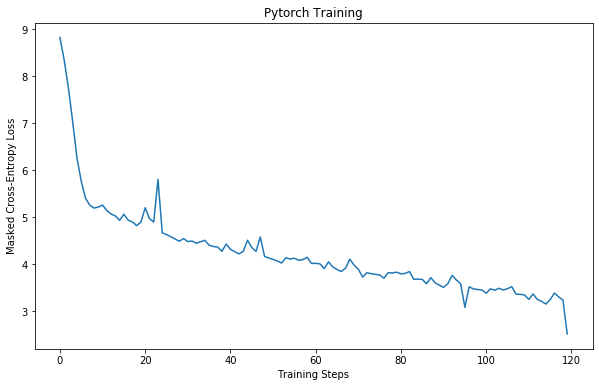

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Pytorch Training')
plt.ylabel('Masked Cross-Entropy Loss')
plt.xlabel('Training Steps')
plt.show()

### Tensorflow

In [20]:
in_embedding_dim = 768
in_rnn_dim = 768

out_embedding_dim = in_embedding_dim
out_rnn_dim = in_rnn_dim

num_epochs = 5
batch_size = 256

#### Dataset and Dataloader

In [21]:
from dataloader_tf import TranslationDatasetTF

In [22]:
dataset_generator = TranslationDatasetTF("data/jsonl/data_train.jsonl")

In [23]:
ds = dataset_generator.generate_dataset(batch_size=batch_size)
num_batches = tf.data.experimental.cardinality(ds).numpy()

In [24]:
in_vocab_size = max(dataset_generator.stoi_src.values()) + 1
out_vocab_size = max(dataset_generator.stoi_tgt.values()) + 1
in_vocab_size, out_vocab_size

(4925, 6822)

In [25]:
encoder_tf = EncoderTF(in_vocab_size, in_embedding_dim, in_rnn_dim)
decoder_tf = DecoderTF(out_vocab_size, out_embedding_dim, out_rnn_dim)
s2s_tf = Seq2SeqTF(encoder_tf, decoder_tf)

In [26]:
opt_tf = tf.optimizers.Adam()
loss_fn_tf = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [27]:
def loss_fn_masked(pred, tgt):
    loss = loss_fn_tf(tgt[:, 1:], pred)
    mask = tf.not_equal(tgt[:, 1:], 0)
    loss = tf.where(mask, loss, 0.)
    loss = tf.reduce_sum(loss) / tf.reduce_sum(tf.cast(mask, dtype=tf.float32))
    return loss

In [28]:
@tf.function(input_signature=[
    tf.TensorSpec([None, None], dtype=tf.int32),
    tf.TensorSpec([None, None], dtype=tf.int32)])
def train_step(src, tgt):
    with tf.GradientTape() as tape:
        pred = s2s_tf([src, tgt])
        loss = loss_fn_masked(pred, tgt)
    
    gradients = tape.gradient(loss, s2s_tf.trainable_variables)
    opt_tf.apply_gradients(zip(gradients, s2s_tf.trainable_variables))
    
    return loss

In [29]:
%%time

losses = []
times = []

for epoch in tqdm.notebook.tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    train_iter = iter(ds)
    
    
    for inputs, targets in tqdm.notebook.tqdm(train_iter, desc=f'Epoch {epoch + 1}',
                                                 total=num_batches, 
                                                 leave=True):
        before = time.perf_counter()
        loss = train_step(*inputs)
        losses.append(loss)
        if epoch > 1:
            times.append(time.perf_counter() - before)



CPU times: user 1min 10s, sys: 13.1 s, total: 1min 23s
Wall time: 1min 28s


In [30]:
#Cutting of the first step to not include the time for initialization and graph building
print("Average execution time per step: {:.2f}ms".format(sum(times[1:]) / len(times[1:]) * 1000))

Average execution time per step: 687.15ms


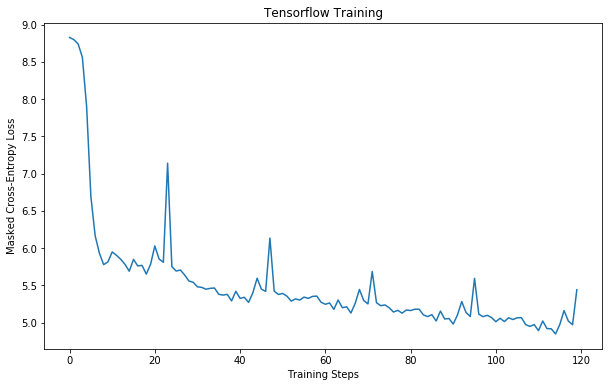

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Tensorflow Training')
plt.ylabel('Masked Cross-Entropy Loss')
plt.xlabel('Training Steps')
plt.show()

Do note that the losses are not direclty comparable due to the difference in omplementation of the loss function.